<a href="https://colab.research.google.com/github/hukim1112/one-day-LLM-FT/blob/main/Processing_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformers, Datasets, and Evaluate 라이브러리를 설치합니다.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

Huggingface 모델을 로드할 때 적절한 AutoModel의 클래스를 선택하면 아래 예시 코드에서와 같이 학습을 위한 loss를 계산하고 역전파할 수 있습니다. 이런 편리한 인터페이스를 활용하기 위해 Huggingface에서 약속된 데이터 형식을 사용할 필요가 있습니다.

In [ ]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

# This is new
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()

# Processing the data

이 코드는 HuggingFace의 datasets 라이브러리를 사용하여 GLUE 데이터셋의 하나인 MRPC(Microsoft Research Paraphrase Corpus)를 로드하고, Transformer 모델을 사용하기 위해 데이터를 토크나이징(tokenizing)하는 과정에 대한 예제를 보여줍니다.

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc") #load_dataset 함수를 사용하여 GLUE 데이터셋 중 MRPC 데이터를 로드
raw_datasets

In [ ]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0] #훈련 데이터셋의 첫 번째 샘플을 확인

In [ ]:
raw_train_dataset.features #훈련 데이터셋의 각 샘플의 특성(feature)들을 확인
# 문장1, 문장2, 연관성 레이블 0 or 1, 데이터 index

In [ ]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs

In [ ]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

tokenizer 객체는 두 개의 문장 묶음을 받았을 때, 자동으로 연결하여 토큰화하는 기능을 가지고 있습니다. transformers 라이브러리의 AutoTokenizer 클래스는 두 개의 입력 문장을 [CLS] sentence1 [SEP] sentence2 [SEP] 형식으로 결합하여 토큰화합니다.

In [ ]:
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"])

In [ ]:
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True,
    truncation=True,
)

In [ ]:
tokenized_dataset['input_ids'][0] #첫 번째 데이터의 토큰 시퀀스를 살펴봅니다.

실제로는 map 함수를 사용해서 일괄처리하는 것이 더 효율적일 수 있습니다.

In [ ]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DataCollator

우리는 앞서 'Training a causal language model' 예제에서 DataCollator를 활용해 학습 데이터를 처리했습니다. DataCollator는 Hugging Face의 transformers 라이브러리에서 제공하는 일종의 유틸리티로, 머신 러닝 특히 자연어 처리(NLP) 모델 학습에 사용되는 데이터를 적절히 준비하고 조정하는 데 중요한 역할을 합니다.

- 배치 생성: 다수의 데이터 샘플을 하나의 배치로 묶는 역할을 합니다. 이 과정에서 각 샘플의 크기나 형태를 조정하여 모든 샘플이 일정한 형식을 가지도록 만듭니다. 자연어 처리에서 데이터 샘플은 문장이나 문서와 같이 길이가 제각각일 수 있습니다. DataCollator는 가장 긴 샘플을 기준으로 나머지 샘플에 패딩(padding)을 추가해 길이를 통일시키는 작업을 수행합니다. 패딩은 모델이 배치 처리를 효율적으로 수행할 수 있게 해 줍니다.

- 라벨 형성: 특정 타입의 DataCollator는 데이터를 변형시키고, 학습 문제에 맞는 레이블을 추가하는 기능을 가지고 있습니다. 예를 들어, DataCollatorForLanguageModeling은 데이터 내의 토큰을 무작위로 마스킹하여 마스크드 언어 모델링(Masked Language Modeling, MLM) 작업에 적합한 형태로 만듭니다.




DataCollator의 대표적인 유형은 아래와 같습니다.


- DataCollatorWithPadding: 토크나이저와 함께 사용되며, 토큰화된 입력을 패딩하여 모든 입력이 같은 길이를 가지도록 합니다. 주로 일반적인 분류나 회귀 태스크에 사용됩니다.

- DataCollatorForTokenClassification: 토큰 분류 태스크에 사용되며, 입력 데이터의 모든 토큰에 레이블을 할당합니다. 예를 들어, Named Entity Recognition(NER) 태스크에 사용됩니다.

- DataCollatorForLanguageModeling: 언어 모델링 태스크에 사용되며, 입력 데이터의 일부 토큰을 무작위로 마스크하고 이를 예측하는 학습을 위해 사용됩니다. BERT의 MLM, GPT의 CLM 학습에 자주 사용됩니다.


DataCollator에 대한 좋은 [아티클](https://medium.com/towards-data-science/data-collators-in-huggingface-a0c76db798d2)을 추천합니다.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples["input_ids"]]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

# Data handling

우리의 데이터는 대부분의 경우 모델을 훈련하기 위해 완벽하게 준비되지 않습니다. 이 섹션에서는 Datasets가 여러분의 데이터 세트를 정리하기 위해 제공하는 다양한 기능을 살펴보겠습니다.


Pandas와 비슷하게 🤗 Datasets는 데이터 내용을 조작하는 여러 함수를 제공합니다.  우리는 앞서 Dataset.map() 방식을 활용했습니다.이 섹션에서는 우리가 사용할 수 있는 다른 함수들을 살펴보겠습니다.

먼저 wget과 unzip 명령어를 사용하여 데이터를 다운로드하고 압축을 풀어야 합니다.








In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

TSV는 구분자로 쉼표 대신 탭을 사용하는 CSV의 변형이기 때문에, csv 로딩 스크립트를 사용하고 load_dataset() 함수에서 delimiter 인자를 다음과 같이 지정하여 이 파일들을 로드할 수 있습니다

In [ ]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

In [ ]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:3]

##### 세 개의 리뷰 샘플 내용

{ '이름 없음: 0' : [ 87571 , 178045 , 80482 ],

  '약물 이름' : [ '나프록센' , '둘록세틴' , '모빅' ],

  '상태' : [ '급성 통풍' , '근육통' , '염증 상태' ],

  '리뷰' : [ '"이전에 언급했던 사람처럼, 저는 알레브를 강력히 믿습니다. 제가 복용하는 처방약보다 통풍에 더 빨리 효과가 나타납니다. 더 이상 처방을 받기 위해 의사에게 갈 필요가 없습니다.....알레브는 효과가 있습니다!"' ,
   '"저는 섬유근육통 통증을 위해 약 1년 반 동안 심발타를 복용했습니다. 진통제이자 항우울제로서 매우 효과적이지만, 부작용이 제가 얻은 이점을 능가했습니다. 저는 불안함과 피곤함에 문제가 있었습니다. 끊임없이, \r\dizziness, 건조한 입, 발의 마비와 따끔거림, 끔찍한 땀. 지금 \r\n끊고 있습니다. 60mg에서 30mg으로, 지금은 15mg으로 줄였습니다. 일주일 정도면 완전히 끊을 겁니다. 섬유성 통증이 돌아오고 있지만, 부작용보다는 그 통증을 참는 게 낫겠어요."' ,
   '"저는 1년 이상 Mobic을 복용했는데 혈압 상승 외에는 부작용이 없었습니다. 무릎과 발목에 심한 통증이 있었는데 Mobic을 복용한 후 완전히 사라졌습니다. 나는 약을 끊으려고 시도했지만 며칠 후에 통증이 돌아왔습니다."' ],

  'rating' : [ 9.0 , 3.0 , 10.0 ],

  'date' : [ '2015년 9월 2일' , '2011년 11월 7일' , '2013년 6월 5일' ],
  
  'usefulCount' : [ 36 , 13 , 128 ]}



 *'Unnamed: 0' 열은 각 환자의 익명화된 ID처럼 보입니다.
'condition' 열에는 대문자와 소문자가 혼합된 레이블이 포함되어 있습니다.
리뷰는 길이가 다양하며 파이썬 줄 구분자 (\r\n)와 HTML 문자 코드(') 등이 혼합되어 있습니다.*

##### 특징 이름 변경

Datasets를 사용하여 이러한 문제들을 어떻게 다룰 수 있는지 알아봅시다. 'Unnamed: 0' 열이 환자 ID라는 가설을 검증하기 위해, Dataset.unique() 함수를 사용하여 각 분할에서 ID의 수가 행의 수와 일치하는지 확인할 수 있습니다

In [ ]:
for split in drug_dataset.keys():
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

이는 우리의 가설을 확인하는 것 같으므로 데이터셋을 조금 정리하여 'Unnamed: 0' 열을 좀 더 이해하기 쉬운 이름으로 변경합시다. DatasetDict.rename_column() 함수를 사용하여 한 번에 두 split에서 열의 이름을 변경할 수 있습니다:

In [ ]:
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)
drug_dataset

##### map 함수를 사용한 전처리

다음으로, Dataset.map()을 사용하여 모든 조건 레이블을 정규화합시다. 3장에서 토큰화를 수행했던 것처럼, drug_dataset의 각 분할의 모든 행에 적용할 수 있는 간단한 함수를 정의할 수 있습니다:

In [ ]:
drug_dataset['train']

In [ ]:
def lowercase_condition(example):
    return {"condition": example["condition"].lower()}


drug_dataset.map(lowercase_condition)

앗, map 함수에서 문제가 발생했네요! 에러에서 조건 열의 일부 항목이 None이라는 것을 추론할 수 있습니다. 이들은 문자열이 아니기 때문에 소문자로 변경할 수 없습니다. Dataset.filter()를 사용하여 이러한 행들을 제거합시다. 이 함수는 Dataset.map()과 비슷하게 작동하며, 데이터셋의 단일 예를 받는 함수를 기대합니다.

In [ ]:
def filter_nones(x):
    return x["condition"] is not None

In [ ]:
(lambda x: x * x)(3)

In [ ]:
(lambda base, height: 0.5 * base * height)(4, 8)

In [ ]:
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

In [ ]:
drug_dataset = drug_dataset.map(lowercase_condition)
# Check that lowercasing worked
drug_dataset["train"]["condition"][:3]

##### 새로운 특징 추가

고객 리뷰를 다룰 때 좋은 관행은 각 리뷰의 단어 수를 확인하는 것입니다. 리뷰는 "Great!"과 같은 단어 하나일 수도 있고, 수천 단어의 긴 에세이일 수도 있으며, 사용 사례에 따라 이러한 극단적인 경우를 다르게 처리해야 할 수 있습니다. 각 리뷰의 단어 수를 계산하기 위해, 우리는 공백으로 텍스트를 분할하는 대략적인 추정법을 사용할 것입니다.

각 리뷰의 단어 수를 세는 간단한 함수를 정의합시다:

In [ ]:
def compute_review_length(example):
    return {"review_length": len(example["review"].split())}

In [ ]:
drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

예상대로, 우리의 훈련 세트에 review_length 열이 추가되었습니다. 이 새로운 열을 Dataset.sort()를 사용하여 정렬함으로써 극단적인 값들이 어떻게 보이는지 확인할 수 있습니다:

In [ ]:
drug_dataset["train"].sort("review_length")[:3]

우리가 의심했듯이, 일부 리뷰는 단어 하나만 포함하고 있습니다. 이는 감정 분석에는 괜찮을 수 있지만, 우리가 질병을 예측하고자 할 때에는 충분한 정보를 제공하지 않을 수 있습니다.

##### 조건부 데이터 제거

Dataset.filter() 함수를 사용하여 30단어 미만의 리뷰를 제거합시다. 조건 열을 다루었던 것과 유사하게, 이 기준 이상의 길이를 가진 리뷰만 남기도록 매우 짧은 리뷰들을 필터링할 수 있습니다:

In [ ]:
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)
print(drug_dataset.num_rows)

마지막으로 다뤄야 할 것은 리뷰에 포함된 HTML 문자 코드의 존재입니다. Python의 html 모듈을 사용하여 이러한 문자들을 변환(unescape)할 수 있습니다. 다음과 같이 할 수 있습니다:

In [ ]:
import html

text = "I&#039;m a transformer called BERT"
html.unescape(text)

In [ ]:
drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

##### map() 메서드 가속하기

Dataset.map() 메서드는 데이터를 변환하거나 전처리하는 데 매우 유용한 도구입니다. 이 메서드는 batched라는 인자를 받을 수 있는데, 이를 True로 설정하면 여러 예제를 한 번에 처리할 수 있습니다. 기본 배치 크기는 1,000이지만, 필요에 따라 조정할 수 있습니다.

예를 들어, 이전의 모든 HTML을 변환하는 작업을 생각해 봅시다. 단일 예제를 하나씩 처리하는 것보다 여러 예제를 한 번에 처리하면 훨씬 빠르게 작업을 완료할 수 있습니다.

In [ ]:
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)

이 코드를 실행하면, 이 명령어가 이전 명령어보다 훨씬 빨리 실행되는 것을 볼 수 있습니다. 이는 우리의 리뷰가 이미 HTML 문자가 변환되었기 때문이 아니라 — 이전 섹션의 지시사항을 batched=True 없이 다시 실행하면, 이전과 같은 시간이 걸립니다. 이는 일반적으로 리스트 표기법이 for 루프에서 동일한 코드를 실행하는 것보다 빠르기 때문이며, 동시에 많은 요소를 접근함으로써 성능을 향상시키기 때문입니다.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["review"], truncation=True)

시간측정 가능

In [ ]:
%time tokenized_dataset = drug_dataset.map(tokenize_function, batched=True)

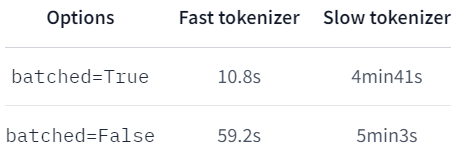

Fast 토크나이저는 Rust 프로그래밍 언어로 작성되어 매우 빠릅니다!

아래처럼 Fast 토크나이저를 쓰지 않으면 느립니다.

In [ ]:
# slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)


# def slow_tokenize_function(examples):
#     return slow_tokenizer(examples["review"], truncation=True)


# tokenized_dataset = drug_dataset.map(slow_tokenize_function, batched=True, num_proc=8)

##### 토크나이징 in map()

토크나이징 과정을 살펴봅시다! 여기서는 예제를 토크나이즈하고 최대 길이 128로 자르겠지만, 첫 번째 조각만이 아닌 텍스트의 모든 조각을 반환하도록 토크나이저에 요청할 것입니다. 이는 return_overflowing_tokens=True 옵션을 사용하여 수행할 수 있습니다.

이 옵션을 활성화하면, 주어진 최대 길이를 초과하는 긴 텍스트가 여러 토큰 조각으로 나뉘어 반환됩니다. 각 조각은 독립적으로 처리될 수 있으며, 이는 특히 긴 문서를 분석할 때 유용합니다. 예를 들어, 뉴스 기사나 연구 논문과 같이 긴 텍스트를 다뤄야 할 때, 전체 내용을 분석하지 않고 일부만을 처리하는 문제를 해결할 수 있습니다.

In [ ]:
def tokenize_and_split(examples):
    return tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )

In [ ]:
result = tokenize_and_split(drug_dataset["train"][1])
[len(inp) for inp in result["input_ids"]]

In [ ]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)

앗, 작동하지 않았네요! 왜 그럴까요? 오류 메시지를 보면 힌트를 얻을 수 있습니다: 한 열의 길이가 1,463이고 다른 열의 길이가 1,000인데 길이가 일치하지 않습니다. Dataset.map() 문서를 살펴보셨다면, 매핑하는 함수에 전달된 샘플 수가 문제임을 기억하실 겁니다; 여기서 1,000개의 예제가 1,463개의 새로운 특성을 생성하여 형태 오류가 발생했습니다.

문제는 두 개의 서로 다른 크기의 데이터셋을 혼합하려고 한다는 것입니다: drug_dataset의 열은 일정한 수의 예제를 가질 것입니다(우리의 오류에서 1,000개), 하지만 우리가 만들고 있는 tokenized_dataset은 더 많을 것입니다(오류 메시지에서 1,463개; return_overflowing_tokens=True를 사용하여 긴 리뷰를 여러 예제로 토크나이징하기 때문에 1,000개보다 많습니다). 이는 Dataset에 적합하지 않으므로,

(1) 이전 데이터셋에서 열을 제거하거나 (2) 새 데이터셋과 같은 크기로 만들어야 합니다.

우리는 remove_columns 인자를 사용하여 (1)을 수행할 수 있습니다:

In [ ]:
tokenized_dataset = drug_dataset.map(
    tokenize_and_split, batched=True, remove_columns=drug_dataset["train"].column_names
)

In [ ]:
len(tokenized_dataset["train"]), len(drug_dataset["train"])

In [ ]:
tokenized_dataset

우리는 또한 (2) 새로운 열과 같은 크기로 오래된 열을 만들어 길이 불일치 문제를 해결할 수 있다고 언급했습니다. 이를 수행하기 위해서는 return_overflowing_tokens=True를 설정했을 때 토크나이저가 반환하는 overflow_to_sample_mapping 필드가 필요합니다. 이 필드는 새로운 특성 인덱스와 그것이 원래 있던 샘플의 인덱스를 연결해 줍니다. 이를 사용하여, 원본 데이터셋에 있는 각 키를 적절한 크기의 값 목록과 연결할 수 있습니다. 이는 각 예제의 값을 새로운 특성을 생성하는 만큼 반복함으로써 수행됩니다.








In [ ]:
def tokenize_and_split(examples):
    result = tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )
    # 새로운 인덱스와 원래 인덱스 간의 매핑 추출
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

In [ ]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

다양한 라이브러리 간의 변환을 가능하게 하기 위해, 🤗 Datasets는 Dataset.set_format() 함수를 제공합니다. 이 함수는 데이터셋의 출력 형식만 변경하므로, 기본 데이터 형식인 Apache Arrow에 영향을 주지 않고 다른 형식으로 쉽게 전환할 수 있습니다. 형식 변환이 현장에서 이루어집니다. 예를 들어, 우리의 데이터셋을 Pandas로 변환하는 방법을 보여드리겠습니다:

In [ ]:
drug_dataset.set_format("pandas")

In [ ]:
drug_dataset["train"][:3]

다음은 drug_dataset["train"]의 모든 요소를 선택하여 전체 훈련 세트에 대한 pandas.DataFrame을 만드는 방법입니다:

In [ ]:
train_df = drug_dataset["train"][:]

In [ ]:
frequencies = (
    train_df["condition"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "condition", "condition": "frequency"})
)
frequencies.head()

In [ ]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

In [ ]:
drug_dataset.reset_format()

우리는 평가를 위해 사용할 수 있는 테스트 세트를 가지고 있지만, 개발 도중 테스트 세트를 그대로 두고 별도의 검증 세트를 만드는 것이 좋은 관행입니다. 검증 세트에서 모델의 성능에 만족하면 테스트 세트에서 최종 정상성 검사를 수행할 수 있습니다. 이 과정은 테스트 세트에 과적합되어 실제 데이터에서 실패하는 모델을 배포하는 위험을 완화하는 데 도움이 됩니다.

In [ ]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
# Add the "test" set to our `DatasetDict`
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean

In [ ]:
drug_dataset_clean.save_to_disk("drug-reviews")

In [ ]:
from datasets import load_from_disk

drug_dataset_reloaded = load_from_disk("drug-reviews")
drug_dataset_reloaded

In [ ]:
for split, dataset in drug_dataset_clean.items():
    dataset.to_json(f"drug-reviews-{split}.jsonl")

In [ ]:
!head -n 1 drug-reviews-train.jsonl

In [ ]:
data_files = {
    "train": "drug-reviews-train.jsonl",
    "validation": "drug-reviews-validation.jsonl",
    "test": "drug-reviews-test.jsonl",
}
drug_dataset_reloaded = load_dataset("json", data_files=data_files)

# Push your own dataset

Hugging Face Hub에 로그인해야 합니다. 다음 명령을 실행하고 login credentials을 입력하세요.








In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
drug_dataset_reloaded.push_to_hub("custom_drug_dataset")

In [ ]:
remote_dataset = load_dataset("hukim1112/custom_drug_dataset", split="train")
remote_dataset

In [ ]:
remote_dataset